# Data Generation for Kura-Sivashinsky Equation

This notebook generates data for the Kura-Sivashinsky equation. The Kura-Sivashinsky equation is a partial differential equation that describes the evolution of a one-dimensional surface. It is given by

$$
\frac{\partial u}{\partial t} = -\nu \frac{\partial^2 u}{\partial x^2} - \frac{\partial u}{\partial x} - \frac{\partial^2 u}{\partial x^2} - \frac{\partial^4 u}{\partial x^4},
$$

where $u(x, t)$ is the surface height at position $x$ and time $t$, and $\nu$ is a positive constant. The Kuramoto-Sivashinsky equation is a nonlinear partial differential equation that exhibits chaotic behavior. It is used as a model for the dynamics of thin films and flame fronts.

ETDRK2 Method

The ETDRK2 method is a numerical method for solving partial differential equations. It is based on the exponential time differencing Runge-Kutta method. The ETDRK2 method is used to solve the Kura-Sivashinsky equation. The ETDRK2 method is a second-order method that is unconditionally stable. It is used to solve stiff partial differential equations.

The ETDRK2 method is based on the following steps:

1. Compute the linear part of the equation using the Fourier transform.
2. Compute the nonlinear part of the equation using the Fourier transform.
3. Compute the exponential time differencing Runge-Kutta method.
4. Compute the inverse Fourier transform to obtain the solution.

Advance first to an intermediate stage:

$$
u_{h}^{*} = e^{L \Delta t} u_{h}^{t} + \Delta t e^{L \Delta t / 2} N(u_{h}^{n}),
$$

where $L$ is the linear part of the equation, $N$ is the nonlinear part of the equation, and $\Delta t$ is the time step.

Then, advance to the next stage:

$$
u_{h}^{n+1} = u_{h}^{*} + e^{L \Delta t} u_{h}^{t} + \Delta t e^{L \Delta t / 2} N(u_{h}^{*}).
$$



In [1]:
import jax 
import jax.numpy as jnp
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import equinox as eqx
import optax
from tqdm.autonotebook import tqdm

/var/folders/1z/t07mkwr55sqbw9ld5m6_dhvm0000gn/T/ipykernel_71274/4237195013.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## Defining Constants

In [21]:
DOMAIN_SIZE = 100.0
NUM_DOF = 250
DT = 0.2

## Creating the KS Equation class

In [8]:
# Create the class to solve the KS equation
class KsEtd2():
    def __init__(
        self,
        L,
        N,
        dt,
    ):
        self.L = L
        self.N = N
        self.dt = dt
        self.dx = L / N

        wavenumbers = jnp.fft.rfftfreq(N, d=L / (N * 2 * jnp.pi))
        self.derivative_operator = 1j * wavenumbers

        linear_operator = - self.derivative_operator**2 - self.derivative_operator**4
        self.exp_term = jnp.exp(dt * linear_operator)
        self.coef_1 = jnp.where(
            linear_operator == 0.0,
            dt,
            (self.exp_term - 1.0) / linear_operator,
        )
        self.coef_2 = jnp.where(
            linear_operator == 0.0,
            dt / 2,
            (self.exp_term - 1.0 - linear_operator * dt) / (linear_operator**2 * dt)
        )

        self.alias_mask = (wavenumbers < 2/3 * jnp.max(wavenumbers))
    
    def __call__(
        self,
        u,
    ):
        u_nonlin = - 0.5 * u**2
        u_hat = jnp.fft.rfft(u)
        u_nonlin_hat = jnp.fft.rfft(u_nonlin)
        u_nonlin_hat = self.alias_mask * u_nonlin_hat
        u_nonlin_der_hat = self.derivative_operator * u_nonlin_hat

        u_stage_1_hat = self.exp_term * u_hat + self.coef_1 * u_nonlin_der_hat
        u_stage_1 = jnp.fft.irfft(u_stage_1_hat, n=self.N)

        u_stage_1_nonlin = - 0.5 * u_stage_1**2
        u_stage_1_nonlin_hat = jnp.fft.rfft(u_stage_1_nonlin)
        u_stage_1_nonlin_hat = self.alias_mask * u_stage_1_nonlin_hat
        u_stage_1_nonlin_der_hat = self.derivative_operator * u_stage_1_nonlin_hat

        u_next_hat = u_stage_1_hat + self.coef_2 * (u_stage_1_nonlin_der_hat - u_nonlin_der_hat)
        u_next = jnp.fft.irfft(u_next_hat, n=self.N)

        return u_next

## Mesh and Initial Conditions

In [36]:
# Creating the mesh and initial condition
mesh = jnp.linspace(0.0, DOMAIN_SIZE, NUM_DOF, endpoint=False)

u_0 = jnp.sin(8 * jnp.pi * mesh / DOMAIN_SIZE)


## Executing the ETDRK2 Method

In [42]:
ks_stepper_etdrk2 = KsEtd2(
    L=DOMAIN_SIZE,
    N=NUM_DOF,
    dt=DT,
)

ks_stepper_etdrk2 = jax.jit(ks_stepper_etdrk2)

In [43]:
u_current = u_0
trj_etdrk2 = [u_current]
for i in range(2001):
    u_current = ks_stepper_etdrk2(u_current)
    trj_etdrk2.append(u_current)

trj_etdrk2 = jnp.stack(trj_etdrk2)

Text(0, 0.5, 'space')

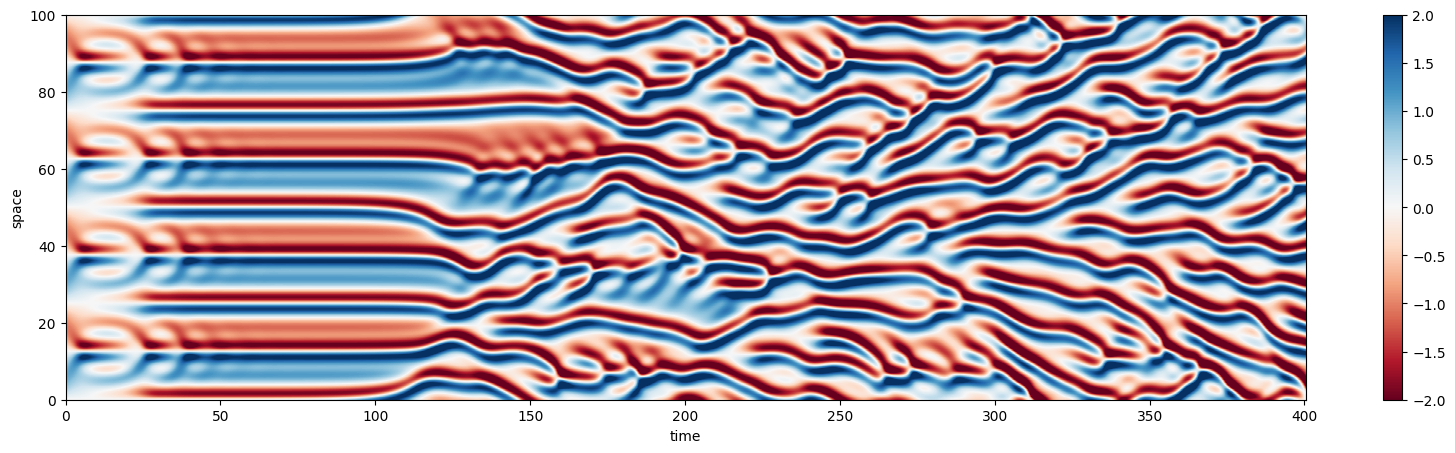

In [45]:
plt.figure(figsize=(20, 5))
plt.imshow(
    trj_etdrk2.T,
    cmap="RdBu",
    aspect="auto",
    origin="lower",
    extent=(0, trj_etdrk2.shape[0] * DT, 0, 100),
    vmin=-2,
    vmax=2,
)
plt.colorbar()
plt.xlabel("time")
plt.ylabel("space")